# arXiv.org LdaModel classifier

The script downloads abstracts for [arXiv.org](https://arxiv.org) papers, selects them by topics and, based on the topic selection, returns abstract of the paper closed to a pre-selected one.

Note that **running this script is quite long**, ~1hour in total! If you want to run it faster, consider reducing number of passes in LdaModel from 50 to, e.g., 10.

In [1]:
#import urllib, urllib3
from bs4 import BeautifulSoup
import requests
import time
import io
import numpy as np
#import nltk
#from nltk.corpus import wordnet as wn
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models.ldamodel import LdaModel

Downloading abstracts using [arXiv.org](https://arxiv.org) API:

In [ ]:
start_time = time.time()
myfile = open("log.txt", "w")
myfile.close()

n_attempts = 100
max_articles_per_attempt = 50
for i in range(n_attempts):
    print("\r\t>>> Downloading {} chunk from {}:".format(i+1, n_attempts), end='')
    n_start = i*max_articles_per_attempt
    url = 'http://export.arxiv.org/api/query?search_query=cat:cs*+AND+submittedDate:[201001010000+TO+201710011159]&sortBy=lastUpdatedDate&sortOrder=descending&&start='+str(n_start)+'&max_results='+str(max_articles_per_attempt)
    url = requests.get(url).content
    soup = BeautifulSoup(url,"html.parser")
    with io.open('log.txt', 'a', encoding='utf8') as logfile:
        for tr in soup.find_all('summary')[2:]:
            logfile.write(u"%s\n" % (tr.text))
end_time = time.time()
print("\nRunning time is {}s".format(end_time-start_time))

with io.open('log.txt', 'r', encoding='utf8') as logfile:
    s = logfile.read().split('\n\n')
    #print(s)
logfile.close()
print(len(s))

The total size of downloaded abstracts for ~25K papers from Computer Science (cs) arXiv category is **~27 MBytes**:

In [4]:
len(str(s))

27572255

Using [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html) to create the relevant dictionary:

In [5]:
# Use CountVectorizer to find three letter tokens, remove stop_words, 
# remove tokens that don't appear in at least 100 documents,
# remove tokens that appear in more than 20% of the documents
vect = CountVectorizer(min_df=100, max_df=0.2, stop_words='english', 
                       token_pattern='(?u)\\b\\w\\w\\w+\\b')
# Fit and transform
X = vect.fit_transform(s)

corpus = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

id_map = dict((v, k) for k, v in vect.vocabulary_.items())

The obtained dictionary contains ~2.8K words:

In [6]:
len(list(vect.vocabulary_.keys()))

2823

For example, it contains the word "robot" (see below):

In [7]:
"robot" in vect.vocabulary_.keys()

True

Using [LdaModel](https://radimrehurek.com/gensim/models/ldamodel.html) to split the papers on 10 topics.
This step is **very slow** (~45 minutes), to reduce computing time consider decreasing number of passes to, e.g., 10.

In [8]:
n_topics = 10
start_time = time.time()
ldamodel = LdaModel(corpus, num_topics=n_topics, random_state=0, passes=50, id2word=id_map) # passes = 100
end_time = time.time()
print("Running time is {}s".format(end_time-start_time))

Running time is 2157.466866493225s


Print 5 major words for each topic:

In [9]:
ldamodel.print_topics(num_topics=n_topics, num_words=5)

[(0,
  '0.019*"control" + 0.012*"game" + 0.011*"agents" + 0.010*"games" + 0.010*"dynamics"'),
 (1,
  '0.030*"learning" + 0.020*"neural" + 0.016*"deep" + 0.015*"training" + 0.014*"networks"'),
 (2,
  '0.016*"security" + 0.013*"mobile" + 0.012*"networks" + 0.012*"devices" + 0.011*"privacy"'),
 (3,
  '0.017*"codes" + 0.012*"code" + 0.011*"language" + 0.009*"systems" + 0.009*"theory"'),
 (4,
  '0.024*"channel" + 0.016*"rate" + 0.012*"power" + 0.012*"information" + 0.010*"scheme"'),
 (5,
  '0.026*"graph" + 0.016*"graphs" + 0.015*"number" + 0.012*"log" + 0.012*"set"'),
 (6,
  '0.012*"energy" + 0.011*"memory" + 0.009*"computing" + 0.009*"distributed" + 0.009*"algorithms"'),
 (7,
  '0.010*"social" + 0.010*"information" + 0.010*"research" + 0.009*"analysis" + 0.008*"users"'),
 (8,
  '0.031*"image" + 0.023*"images" + 0.016*"detection" + 0.016*"object" + 0.013*"video"'),
 (9,
  '0.010*"matrix" + 0.010*"methods" + 0.009*"algorithms" + 0.008*"linear" + 0.008*"optimization"')]

Adding abstract of a new paper ["Line Formation by Fat Robots under Limited Visibility"](https://arxiv.org/abs/1710.09398):

In [10]:
new_doc = ["This paper proposes a distributed algorithm for a set of tiny unit disc shaped robot \
to form a straight line. The robots are homogeneous, autonomous, anonymous. They observe their \
surrounding up to a certain distance, compute destinations to move to and move there. They do not have any \
explicit message sending or receiving capability. They forget their past observed or computed data. \
The robots do not have any global coordinate system or origin. Each robot considers its position as its origin. \
However, they agree on the X and Y axis. The robots are not aware of the total number of robots in the system. \
The algorithm presented in this paper assures collision free movements of the robots. \
To the best of our knowledge this paper is the first reported result on line formation by fat robots \
under limited visibility."]

Topics and corresponding scores of a given abstract:

In [11]:
def topic_distribution(doc, num_topics = n_topics):
    
    topics_array = np.zeros(num_topics)
    X1 = vect.transform(doc)
    corpus1 = gensim.matutils.Sparse2Corpus(X1, documents_columns=False)
    list_1 = list(ldamodel.get_document_topics(bow=corpus1))[0]
    for items in list_1:
        topics_array[items[0]] = items[1]
    return topics_array
for i, item in enumerate(topic_distribution(new_doc)):
    if item > 0:
        print(i, item)

0 0.699768692661
2 0.0803946568701
5 0.204939500149


To calculate the final "closeness score", I use the simple dot product of individual topic scores:

In [12]:
def calculate_score(doc1, new_doc):
    
    return np.dot(topic_distribution(doc1), topic_distribution(new_doc))

Return abstract of a paper, maximally resembling that of a given paper:

In [13]:
def return_max_resembling_paper():
    
    max_score = 0
    start_time = time.time()
    for i, doc in enumerate(s):
        score = calculate_score(new_doc, [doc])
        print("\r\t>>> Progress\t:{:.4%}".format((i + 1)/len(s)), end='')
        #print(i, score, topic_distribution([doc]))
        if score > max_score:
            best_i = i
            max_score = score
    end_time = time.time()
    print("\nRunning time is {}s".format(end_time-start_time))
    return max_score, best_i

In [14]:
score, best_i = return_max_resembling_paper()
print(">>> Best score is:", score)
print(">>> Abstract of the closest paper:")
print(s[best_i])
print(">>> Abstract of initial paper:")
print(new_doc[0])
for i, item in enumerate(topic_distribution([s[best_i]])):
    if item > 0:
        print(i, item) 

	>>> Progress	:100.0000%
Running time is 99.09927582740784s
>>> Best score is: 0.687648686163
Abstract of the closest paper:
  This paper proposes control laws ensuring the stabilization of a time-varying
desired joint trajectory, as well as joint limit avoidance, in the case of
fully-actuated manipulators. The key idea is to perform a parametrization of
the feasible joint space in terms of exogenous states. It follows that the
control of these states allows for joint limit avoidance. One of the main
outcomes of this paper is that position terms in control laws are replaced by
parametrized terms, where joint limits must be avoided. Stability and
convergence of time-varying reference trajectories obtained with the proposed
method are demonstrated to be in the sense of Lyapunov. The introduced control
laws are verified by carrying out experiments on two degrees-of-freedom of the
humanoid robot iCub.
0 0.982688615601


As we see, the paper looks relevant although the score is not very high (~0.69). In fact, scores very close to 1 would be suspicious (plagiarism?).

This is **very first step** (I started the project yesterday, 28-Oct-2017), so a number of improvements should be made, such as
- more professional wording (including 2-grams), 
- more detailed topic modeling, 
- faster implementation,
- website and (or) app

are clearly missing.

# Visualisation of clustered papers by topics

In [17]:
topic_distribution([s[0]])

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.12936774,
        0.15370662,  0.        ,  0.        ,  0.        ,  0.70771363])

In [19]:
len(s)

25399

In [27]:
papers_df = pd.DataFrame()
for i in range(len(s)):
    print("\r\t>>> Progress\t:{:.4%}".format((i + 1)/len(s)), end='')
    for k in range(10):
        papers_df.loc[i, k] = topic_distribution([s[i]])[k]
papers_df.head()

	>>> Progress	:100.0000%

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.000000,0.0,0.000000,0.129323,0.153710,0.0,0.000000,0.000000,0.707726
1,0.0,0.000000,0.0,0.760573,0.000000,0.103109,0.0,0.111211,0.000000,0.000000
2,0.0,0.000000,0.0,0.000000,0.000000,0.980432,0.0,0.000000,0.000000,0.000000
3,0.0,0.000000,0.0,0.000000,0.000000,0.979540,0.0,0.000000,0.000000,0.000000
4,0.0,0.725167,0.0,0.000000,0.000000,0.195536,0.0,0.000000,0.055969,0.000000


In [28]:
papers_df.describe()

,0,1,2,3,4,5,6,7,8,9
count,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000,25399.000000
mean,0.069317,0.133194,0.052548,0.092199,0.072186,0.114246,0.090191,0.145079,0.079744,0.139936
std,0.148101,0.222715,0.121386,0.176281,0.179479,0.219060,0.164089,0.227289,0.166084,0.217337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.058504,0.198253,0.029038,0.108225,0.024474,0.121556,0.118357,0.217203,0.066993,0.212534
max,0.982689,0.989533,0.983631,0.990108,0.992104,0.992622,0.992034,0.991587,0.987140,0.992104


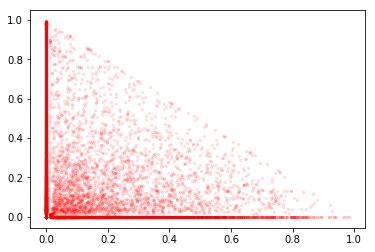

In [43]:
import matplotlib.pyplot as plt
plt.scatter(papers_df[0], papers_df[5], alpha=0.1, s=5, c='red')
plt.show()

In [45]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, random_state=0)
pca.fit(papers_df)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=0,
  svd_solver='auto', tol=0.0, whiten=False)

In [46]:
papers_pca = pca.transform(papers_df)

In [48]:
papers_pca[:10]

array([[ 0.32956735, -0.25233007],
       [ 0.14372466,  0.19017084],
       [ 0.58810214,  0.18162888],
       [ 0.58758687,  0.18147491],
       [-0.22305122, -0.3923237 ],
       [-0.03689385, -0.27801935],
       [-0.45555793, -0.47721299],
       [-0.3812067 , -0.48086885],
       [-0.11067795, -0.24692628],
       [ 0.12774047,  0.04667575]])

In [54]:
papers_pca[0]

array([ 0.32956735, -0.25233007])

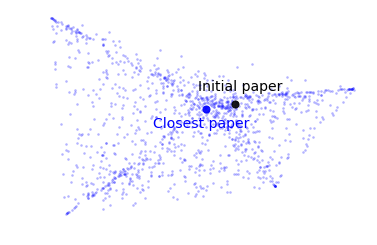

In [98]:
# plot each 20th paper:
for i in range(1, len(papers_pca), 20):
    plt.scatter(papers_pca[i][0], papers_pca[i][1], alpha=0.2, s=3, c='blue')
# plot
plt.scatter(papers_pca[best_i][0], papers_pca[best_i][1], alpha=0.9, s=50, c='blue')
# plot 
new_doc_df = pd.DataFrame(topic_distribution(new_doc))
plt.scatter(pca.transform(new_doc_df.T)[0][0], pca.transform(new_doc_df.T)[0][1], alpha=0.9, s=50, c='black')
plt.tick_params(axis ='both', which='major', length=0)
plt.tick_params(axis ='both', which='minor', length=0)
plt.axis('off')
plt.figtext(x=0.60, y=0.59, s='Initial paper', ha='center', size=14, color='black')
plt.figtext(x=0.51, y=0.46, s='Closest paper', ha='center', size=14, color='blue')
plt.savefig("visual-2.pdf", format="pdf", transparent=True,rasterized=True,dpi=300)

plt.show()